In [1]:
%matplotlib inline

import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import spacy
#import gensim.downloader as api

#info = api.info()  # show info about available models/datasets
#model = api.load("glove-twitter-25")  # download the model and return as object ready for use

#nlp = spacy.load('en')

Read the Readme here:
https://github.com/RaRe-Technologies/gensim-data

# Getting the dataset

We will use here the dataset provided by the authors we will create a helper function to extract the features that we want.

In [2]:
data = pd.read_json("diplomacy_data/diplomacy_data.json")
data.head(2)

,seasons,game,betrayal,idx,people
0,"[{'season': 1906.5, 'interaction': {'victim': ...",74,True,0,AT
1,"[{'season': 1911.5, 'interaction': {'victim': ...",165,False,1,EG


In [3]:
def last_support(entry):
    """
    This function returns the last season of friendship. The code is inspired by the provided code from
    the authors
    """
    last_support = None
    for season in entry[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

def treat_msg_season(df):
    """
    This function loops over the whole dataset and creates a dictionnary with the set of features for each season 
    with its associated boolean (betrayal or not )
    """
    data_victim = {'features':[], 'betrayed':[]} # data of the (potential) victim 
    data_betrayer = {'features':[], 'betrayed':[]} # data of the (potential) betrayer
    for i in range(len(df.seasons.values)):
        entry = df['seasons'][i] # pick each entry
        for j in range(len(entry)): # pick each season
            season = entry[j]
            tab_vi = []
            tab_be = []
            if season['season'] <= last_support(entry): # check if the season is below the last season of friendship
                tab_vi.append(season['messages']['victim'])
                tab_be.append(season['messages']['betrayer'])
                if len(tab_be) != 0 and len(tab_vi) != 0: # keep only cases where both players have sent messages
                    data_victim['features'].append(tab_vi)
                    data_victim['betrayed'].append(df.betrayal.values[i])
                    data_betrayer['features'].append(tab_be)   
                    data_betrayer['betrayed'].append(df.betrayal.values[i])
    return data_victim, data_betrayer

data_victim, data_betrayer = treat_msg_season(data)

In [4]:
def to_dict(message):
    sentiment_positive = message['sentiment']['positive']
    sentiment_neutral = message['sentiment']['neutral']
    sentiment_negative = message['sentiment']['negative']
    n_requests = message['n_requests']
    frequent_words = message['frequent_words']
    n_words = message['n_words']
    politeness = message['politeness']
    n_sentences = message['n_sentences']
    return {"sentiment_positive": sentiment_positive,
           "sentiment_neutral": sentiment_neutral,
           'sentiment_negative': sentiment_negative,
           'n_requests': n_requests,
           'frequent_words': frequent_words,
           'n_words': n_words,
           'politeness': politeness,
           'n_sentences': n_sentences}
    


def preprocessing(df):
    result = []
    for row in df.iterrows():
        row = row[1]
        betrayal = row['betrayal']
        idx = row['idx']
        for season in row['seasons']:
            s = season['season']
                
            last_s = last_support(row['seasons'])+0.5 # the betrayal occurs one season after the last support
            if s <= last_support(row['seasons']) and len(season['messages']['betrayer']) and len(season['messages']['victim']): # here we also have to consider the last season before betrayal
                interaction_victim = season['interaction']['victim']
                interaction_betrayer = season ['interaction']['betrayer']
                for m_vic in season['messages']['victim']:
                    data = to_dict(m_vic)
                    data['role'] = 'victim'
                    data['season'] = s
                    data['betrayal'] = betrayal
                    data['season_betrayal'] = last_s
                    data['season_before_betrayal'] = (last_s-s)/0.5
                    data['idx'] = idx
                    result.append(data)
                for m_bet in season['messages']['betrayer']:
                    data = to_dict(m_bet)
                    data['role'] = 'betrayer'
                    data['season'] = s
                    data['betrayal'] = betrayal
                    data['season_betrayal'] = last_s
                    data['season_before_betrayal'] = (last_s-s)/0.5
                    data['idx'] = idx
                    result.append(data)
                            
    return pd.DataFrame(result).set_index(['idx', 'season'])

In [5]:
df = preprocessing(data)
df.head(5)

sentiment_positive  sentiment_neutral  sentiment_negative  \
idx season                                                              
0   1906.5                   0                  0                   2   
    1906.5                   1                  1                   4   
    1906.5                   1                  2                   1   
    1906.5                   4                  2                  13   
    1906.5                   1                  3                   5   

            n_requests                                     frequent_words  \
idx season                                                                  
0   1906.5           1  [just, bot, ,, ., take, unit, war, retreat, di...   
    1906.5           2  [armies, north, the, armies, on, ., your, with...   
    1906.5           2  [?, going, for, ser, balance, a, to, of, give,...   
    1906.5           8  [only, he, alb, ., forced, italy's, is, be, .,...   
    1906.5           7  [more, let, keep, we, side, we, don't, to, ., ...   

            n_words  politeness  n_sentences      role  betrayal  \
idx season                                                         
0   1906.5       35    0.367200            2    victim      True   
    1906.5       77    0.932326            6    victim      True   
    1906.5       55    0.983373            4    victim      True   
    1906.5      313    0.957072           19    victim      True   
    1906.5      146    0.832023            9  betrayer      True   

            season_betrayal  season_before_betrayal  
idx season                                           
0   1906.5           1909.5                     6.0  
    1906.5           1909.5                     6.0  
    1906.5           1909.5                     6.0  
    1906.5           1909.5                     6.0  
    1906.5           1909.5                     6.0

In [6]:
def get_nb_msg(data):
    """
    Get the mean number of messages sent per season
    """
    tab = []
    for features in data["features"]:
        tab.append(len(features[0]))
    return tab

print("In each season, potential betrayers send in average {}, with a maximum of {} messages".format(np.mean(get_nb_msg(data_betrayer)), np.max(get_nb_msg(data_betrayer))))
print("In each season, potential victims send in average {}, with a maximum of {} messages".format(np.mean(get_nb_msg(data_victim)), np.max(get_nb_msg(data_victim))))

In each season, potential betrayers send in average 1.627498001598721, with a maximum of 38 messages
In each season, potential victims send in average 1.515587529976019, with a maximum of 28 messages


In [7]:
def get_lexicon_words(entry):
    """
    get the set of lexicon words for each entry of the dataset
    1 entry = 1 row = 1 set of messages
    Can be improved
    """
    for entries in entry[0]: #loop over the messages
        # get the lexicon words
        di_words = entries["lexicon_words"]
        tab_words = []
        for key in di_words:
            tab = di_words[key]
            for words in tab:
                word = words.split(' ')
                for w in word:
                    if w not in tab_words:
                        tab_words.append(w)
    return tab_words

test = get_lexicon_words(data_victim["features"][-1])


# Feature extraction

In [8]:
df[(df["betrayal"]==True) & (df["role"] == "betrayer")].reset_index().groupby('season_before_betrayal').count()['idx']

season_before_betrayal
1.0    343
2.0    360
3.0    314
4.0    277
5.0    231
6.0    156
7.0     94
8.0     78
9.0     42
Name: idx, dtype: int64

There are 367 instances of 1 season before betrayal, 379 instances of 2 seasons before betrayal etc.

## Predicting iminent betrayal - Logistic Regression

Here we consider only messages that have been exchanged one season before the betrayal

In [9]:
data_1 = df[(df["season_before_betrayal"]==1) & (df["role"] == "betrayer")].reset_index().copy()
data_1.head(10)

,idx,season,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,frequent_words,n_words,politeness,n_sentences,role,betrayal,season_betrayal,season_before_betrayal
0,0,1909.0,0,1,2,2,"[would, on, other, france, i, that, to, think,...",42,0.951652,3,betrayer,True,1909.5,1.0
1,0,1909.0,0,0,2,1,"[know, the, the, ,, game, that, unless, on, wa...",51,0.867535,2,betrayer,True,1909.5,1.0
2,0,1909.0,0,1,0,1,"[france, for, see, now, would, did, just, what...",14,0.464116,1,betrayer,True,1909.5,1.0
3,3,1902.5,0,2,4,4,"[bla, not, of, always, a, if, goes, take, ,, t...",134,0.855036,6,betrayer,False,1903.0,1.0
4,3,1902.5,1,0,2,2,"[about, to, aeg, was, now, anyway, has, gre, b...",62,0.218056,3,betrayer,False,1903.0,1.0
5,4,1911.0,0,2,1,2,"[war, after, and, which, that, into, may, you,...",44,0.784303,3,betrayer,False,1911.5,1.0
6,4,1911.0,0,3,0,0,"[another, game, ., we, i, ., think, 6, have, ....",18,0.690164,3,betrayer,False,1911.5,1.0
7,4,1911.0,1,1,0,0,"[vie, into, and, ., you, tun, also, ahead, sup...",17,0.600676,2,betrayer,False,1911.5,1.0
8,5,1906.0,3,0,1,1,"[and, through, ., sounds, enter, to, i'm, move...",33,0.852749,4,betrayer,True,1906.5,1.0
9,8,1906.0,1,2,0,1,"[on, talk, ., write, ., and, if, more, perfect...",20,0.480527,3,betrayer,True,1906.5,1.0


In [10]:
data_1.head(10)

,idx,season,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,frequent_words,n_words,politeness,n_sentences,role,betrayal,season_betrayal,season_before_betrayal
0,0,1909.0,0,1,2,2,"[would, on, other, france, i, that, to, think,...",42,0.951652,3,betrayer,True,1909.5,1.0
1,0,1909.0,0,0,2,1,"[know, the, the, ,, game, that, unless, on, wa...",51,0.867535,2,betrayer,True,1909.5,1.0
2,0,1909.0,0,1,0,1,"[france, for, see, now, would, did, just, what...",14,0.464116,1,betrayer,True,1909.5,1.0
3,3,1902.5,0,2,4,4,"[bla, not, of, always, a, if, goes, take, ,, t...",134,0.855036,6,betrayer,False,1903.0,1.0
4,3,1902.5,1,0,2,2,"[about, to, aeg, was, now, anyway, has, gre, b...",62,0.218056,3,betrayer,False,1903.0,1.0
5,4,1911.0,0,2,1,2,"[war, after, and, which, that, into, may, you,...",44,0.784303,3,betrayer,False,1911.5,1.0
6,4,1911.0,0,3,0,0,"[another, game, ., we, i, ., think, 6, have, ....",18,0.690164,3,betrayer,False,1911.5,1.0
7,4,1911.0,1,1,0,0,"[vie, into, and, ., you, tun, also, ahead, sup...",17,0.600676,2,betrayer,False,1911.5,1.0
8,5,1906.0,3,0,1,1,"[and, through, ., sounds, enter, to, i'm, move...",33,0.852749,4,betrayer,True,1906.5,1.0
9,8,1906.0,1,2,0,1,"[on, talk, ., write, ., and, if, more, perfect...",20,0.480527,3,betrayer,True,1906.5,1.0


In [11]:
X, Y = data_1[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'n_sentences', 'politeness']].values, 1*data_1['betrayal'].values

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

def normalize(x):
    x_temp = x.copy()
    for i in range(len(x[0, :])-1):
        m = np.mean(x[:, i])
        s = np.std(x[:, i])
        x_temp[:, i] -= m
        x_temp[:, i] /= s
    return x_temp

x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)

### An intuition for finding the best model / configuration of features for logistic regression

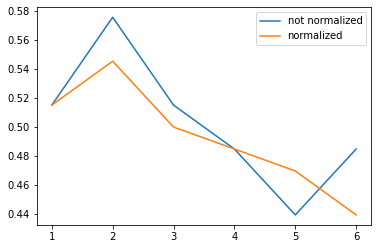

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def log_reg_pipeline(data, features, normalize_=True, print_=True):
    X, Y = data[features].values, 1*data['betrayal'].values
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
    if normalize_:
        x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)
        clf = LogisticRegression(random_state=0).fit(x_train_nor, y_train)
        score = clf.score(x_test_nor, y_test)
        if print_:
            print("score on the test set : {}".format(score))
        return clf, score
    else:
        clf = LogisticRegression(random_state=0).fit(x_train, y_train)
        score = clf.score(x_test, y_test)
        if print_:
            print("score on the test set : {}".format(score))
        return clf, score

features = [
            ['politeness'],
            ['n_words', 'politeness'],
            ['n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'n_requests', 'n_words', 'politeness'],
           ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness']]

ax1 = []
ax2 = []
ax3 = []

for feature in features:
    _, score = log_reg_pipeline(data_1, feature, False, False)
    _, score_nor = log_reg_pipeline(data_1, feature, True, False)
    ax1.append(len(feature))
    ax2.append(score)
    ax3.append(score_nor)
    
_ = plt.plot(ax1, ax2)
_ = plt.plot(ax1, ax3)
_ = plt.legend(['not normalized', 'normalized'])

### The feed forward model + some preprocessing to understand better the above

In [14]:
features_data = df.copy()

# Now train just for the betrayer role for changes, although we could add data for both?
features_data = features_data[features_data['role'] == 'betrayer']
features_data = features_data[features_data['betrayal'] == True]

features_data = features_data.drop(columns=['frequent_words', 'season_betrayal', 'role', 'betrayal'])

In [15]:
aggreagted_features_per_season = features_data.groupby(['idx', 'season'], as_index=False).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'season_before_betrayal': 'min'
})

X = aggreagted_features_per_season[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',
       'n_requests', 'n_words', 'politeness', 'n_sentences']]
Y = (aggreagted_features_per_season['season_before_betrayal'] == 1.0).values.astype('float32')

In [16]:
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,politeness,n_sentences
0,1.333333,1.333333,1.500000,3.666667,489,0.803328,25
1,0.142857,0.857143,1.285714,1.285714,280,0.560083,16
2,2.000000,2.500000,2.000000,5.500000,333,0.982703,13
3,1.800000,0.800000,2.200000,3.200000,449,0.748802,24
4,1.000000,1.000000,1.000000,2.000000,78,0.899161,6


In [17]:
X.shape

(663, 7)

In [18]:
# Check imbalance of labels
np.sum(Y == 1)/(Y.shape[0]) # ~18%; idk why not ~14

0.19457013574660634

In [19]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train) # use the mean, std of the training to standardize the test
x_test = scaler.transform(x_test)

In [20]:
import keras
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import L1, L2, L1L2
from keras import metrics


# Please note that these are computed per batch, not on entire validation
# and might be misleading
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

FEATURES_NUM = X.shape[-1]

def get_feed_forward_model():
    model = Sequential()
    model.add(Dense(units=512, activation='relu', kernel_regularizer=L1L2(1e-6), input_shape=(FEATURES_NUM,)))
    model.add(Dense(units=256, activation='relu', kernel_regularizer=L1L2(1e-6)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    model.summary()
    
    return model

ModuleNotFoundError: No module named 'keras'

In [21]:
# To address imbalance, compute the weights
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y)
class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: 0.6207865168539326, 1: 2.5697674418604652}

In [22]:
BATCH_SIZE = 32
EPOCHS = 100

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = keras.callbacks.ModelCheckpoint('best_model_tmp.h5', monitor='val_loss', mode='min', save_best_only=True)

model = get_feed_forward_model()
result = model.fit(
    x_train, 
    y_train, 
    batch_size = BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_test, y_test), 
    callbacks = [es, mc],
    class_weight=class_weights, verbose=0)

NameError: name 'keras' is not defined

In [23]:
from matplotlib import pyplot

pyplot.plot(result.history['loss'], label='train')
pyplot.plot(result.history['val_loss'], label='test')

pyplot.legend()
pyplot.show()

NameError: name 'result' is not defined

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# TODO: apply bootstrapping 
def matthews_corr_coef(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))

def evaluate_model(y_true, y_pred):
    n = y_true.shape[0]
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    f1 = f1_score(y_true, y_pred)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = np.sum(y_pred == y_true) / n
    
    mmc = matthews_corr_coef(y_true, y_pred)
    
    return {'f1': np.round(f1, decimals=3),
            'mmc': np.round(mmc, decimals=6),
            'acc': np.round(accuracy, decimals=3),
            'precision': np.round(precision, decimals=3),
            'recall': np.round(recall, decimals=3),
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
           }

# This results are cool, but they are much lower when we will do bootstrapping
model.load_weights('best_model.h5')
y_pred = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
y_pred_bool = y_pred > 0.5
evaluate_model(y_test, y_pred_bool)

NameError: name 'model' is not defined

## Short attempt to the time series idea

In [25]:
TIMESTEPS = 3

def split_sequence(X_data, y_data, n_steps):
    X, y = list(), list()
    for i in range(len(X_data)):
        end_ix = i + n_steps
        if end_ix > len(X_data)-1:
            break
        seq_x = X_data[i:end_ix]
        seq_y = y_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

scaler = StandardScaler()
Xp = scaler.fit_transform(X)
x_seq, y_seq = split_sequence(Xp, Y, TIMESTEPS)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size=0.10, shuffle=True, random_state=42)

In [27]:
def get_vanilla_lstm_model():
    model = Sequential()
    model.add(keras.layers.LSTM(30, activation='relu', kernel_regularizer=keras.regularizers.L1L2(1e-6), input_shape=(TIMESTEPS, FEATURES_NUM)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

    return model

BATCH_SIZE = 32
EPOCHS = 100

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = keras.callbacks.ModelCheckpoint('best_model_tmp.h5', monitor='val_loss', mode='min', save_best_only=True)

model = get_vanilla_lstm_model()
result = model.fit(
    x_train, 
    y_train, 
    batch_size = BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_test, y_test), 
    callbacks = [es, mc],
    class_weight=class_weights, verbose=1)

model.load_weights('best_model_tmp.h5')
y_pred = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
y_pred_bool = y_pred > 0.5
evaluate_model(y_test, y_pred_bool)

NameError: name 'keras' is not defined

## Predicting iminent betrayal - Decisions Trees

### Preprocessing : 
Features: /


Label: Is there a betrayal the season after ?

In [28]:
X, Y = data_1[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness']].values, (data_1['betrayal'].values == 1).astype(np.int)

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)


param_grid = {'n_estimators': range(1, 1001, 100), 'max_depth': range(1, 6), 'learning_rate': np.arange(0.05, 1, 0.05)}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid_search.fit(x_train_nor, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'max_depth': range(1, 6),
                         'n_estimators': range(1, 1001, 100)})

In [32]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# learning_rate = 0.3, max_depth = 1, n_estimators = 101

Best parameters: {'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 101}
Best cross-validation score: 0.55


In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)


param_grid2 = {'n_estimators': range(1, 1001, 10), 'max_depth': range(1, 6)}
grid_search2 = GridSearchCV(GradientBoostingClassifier(learning_rate=0.3), param_grid2, cv=5)
grid_search2.fit(x_train_nor, y_train)
print("Best parameters: {}".format(grid_search2.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search2.best_score_))

Best parameters: {'max_depth': 2, 'n_estimators': 21}
Best cross-validation score: 0.55


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
range_trees = range(2, 100)
range_depth = range(1, 10)
range_learning = np.arange(0.1, 1, 0.1)
scores = list()
features_list = list()

for n_tree in range_trees:
    for depth in range_depth:
        for learning_rate in range_learning:
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
            x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)
            clf = GradientBoostingClassifier(random_state=0, n_estimators=n_tree, 
                                             max_depth=depth, 
                                             learning_rate=learning_rate)
            clf.fit(x_train_nor, y_train)
            y_pred = clf.predict(x_test_nor)
            results = evaluate_model(y_test, y_pred)
            results['n_tree'] = n_tree
            results['max_depth'] = depth
            results['learning_rate'] = learning_rate
            results['matthews_score'] = matthews_corr_coef(y_test, y_pred)
            scores.append(results)
            features_importance = clf.feature_importances_
            features = {'sentiment_positive': features_importance[0],
                       'sentiment_neutral': features_importance[1],
                       'sentiment_negative': features_importance[2],
                       'n_requests': features_importance[3],
                       'n_words': features_importance[4],
                       'n_sentences': features_importance[5],
                       'politeness': features_importance[6]}
            features_list.append(features)
    #print(results)
    
opti_scores = pd.DataFrame(scores)
features = pd.DataFrame(features_list).apply(func=(lambda x: x.mean()), axis=0)


<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: invalid value encountered in true_divide
  return (TN*TP - FP*FN)/np.sqrt((TN+FN)*(FP+TP)*(TN+FP)*(FN+TP))
<ipython-input-24-53fd75de9dac>:8: RuntimeWarning: i

KeyboardInterrupt: 

In [ ]:
best_features = opti_scores[opti_scores['f1'] == np.array(opti_scores['f1']).max()][['n_tree', 'max_depth', 'learning_rate']]
# Best features: max_depth = 1, learning_rate = 0.6, n_trees = 8
best_features

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize=(16, 5))
ax[0].bar(x=range(len(features)), height=features.values)
ax[0].set_xticks(range(len(features)))
ax[0].set_xticklabels(features.index, rotation = 45)
ax[0].set_ylabel('feature importance')


ax[1].plot(opti_scores['n_tree'], opti_scores['matthews_score'])
ax[1].set_ylabel('matthews score')
ax[1].set_xlabel('number of trees')

ax[2].plot(opti_scores['n_tree'], opti_scores['f1'])
ax[2].set_ylabel('f1 score')
ax[2].set_xlabel('number of trees')

plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
x_train_nor, x_test_nor = normalize(x_train), normalize(x_test)
best_clf = GradientBoostingClassifier(random_state=0, 
                                      n_estimators=8, 
                                      max_depth=1, 
                                      learning_rate=0.6)
best_clf.fit(x_train_nor, y_train)
features_importance = best_clf.feature_importances_
y_pred = best_clf.predict(x_test_nor)
results = evaluate_model(y_test, y_pred)
features = pd.Series({'sentiment_positive': features_importance[0],
                       'sentiment_neutral': features_importance[1],
                       'sentiment_negative': features_importance[2],
                       'n_requests': features_importance[3],
                       'n_words': features_importance[4],
                       'n_sentences': features_importance[5],
                       'politeness': features_importance[6]})

fig, ax = plt.subplots(ncols = 1, figsize=(6, 5))
ax.bar(x=range(len(features)), height=features.values)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features.index, rotation = 45)
ax.set_ylabel('feature importance')
# Difference in the importance of features

# NLP pipeline

### stopwords removal

In [ ]:
with codecs.open("helpers/stopwords.txt", encoding='utf-8') as h:
    stopwords = h.read().split('\n')

# Spacy & Glove word embedding

Here we use the spacy library to compute the embeddings. We have to try also with Glove and Word2Vec

In [ ]:
from scipy.spatial import distance

def get_word_embedding(word):
    return nlp(word).vector

def get_word_embedding_model(model, word):
    return model[word]

print("Word :{} , embedding : {}".format(test[1], get_word_embedding_model(model, test[1])))
#model.most_similar("man")

# Word2Vec embedding